In [1]:
import pandas as pd

df = pd.read_csv('cleaned.csv')
df["date"] = pd.to_datetime(df["date"])

# Create lag features
for lag in [1, 2, 3, 4, 5]:
    df[f"weighted_ili_lag_{lag}"] = df["weighted_ili"].shift(lag)

df.dropna(inplace=True)

df.head()

,Unnamed: 0,region_type,year,week,weighted_ili,unweighted_ili,age_0_4,age_25_49,age_5_24,age_50_64,age_65,ilitotal,num_providers,total_patients,date,weighted_ili_lag_1,weighted_ili_lag_2,weighted_ili_lag_3,weighted_ili_lag_4,weighted_ili_lag_5
5,645,National,2010,6,2.09695,2.03434,5496,2644.0,5577,1006.0,658,15381,1977,756068,2010-02-08,2.11387,1.96908,1.88072,1.86738,1.90712
6,646,National,2010,7,1.90294,1.97649,5388,2649.0,5536,994.0,498,15065,1954,762208,2010-02-15,2.09695,2.11387,1.96908,1.88072,1.86738
7,647,National,2010,8,1.96951,1.99362,5040,2943.0,6207,1218.0,679,16087,1990,806925,2010-02-22,1.90294,2.09695,2.11387,1.96908,1.88072
8,648,National,2010,9,1.92331,1.85383,4281,2763.0,5685,1085.0,672,14486,1953,781411,2010-03-01,1.96951,1.90294,2.09695,2.11387,1.96908
9,649,National,2010,10,1.89659,1.86730,4612,2660.0,5270,1112.0,700,14354,1946,768702,2010-03-08,1.92331,1.96951,1.90294,2.09695,2.11387


In [2]:
# Define updated feature set and target
features = [f"weighted_ili_lag_{lag}" for lag in [1, 2, 3, 4, 5]]
X = df[features]
y = df["weighted_ili"]

split_index = int(len(df) * 0.8)
X_train, X_test = X.iloc[:split_index], X.iloc[split_index:]
y_train, y_test = y.iloc[:split_index], y.iloc[split_index:]


In [3]:
# Random Forest

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

# Train Random Forest
rf_model = RandomForestRegressor(random_state=42)
rf_model.fit(X_train, y_train)
rf_preds = rf_model.predict(X_test)

# Calculate RMSE (manual sqrt)
rf_rmse = mean_squared_error(y_test, rf_preds) ** 0.5
rf_rmse

0.35827384297495457

In [4]:
from sklearn.linear_model import LinearRegression

# Train and evaluate Linear Regression
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)
lr_preds = lr_model.predict(X_test)
lr_rmse = mean_squared_error(y_test, lr_preds) ** 0.5

lr_rmse

0.3255233807490401

In [5]:
from xgboost import XGBRegressor

# Train and evaluate XGBoost
xgb_model = XGBRegressor(random_state=42)
xgb_model.fit(X_train, y_train)
xgb_preds = xgb_model.predict(X_test)
xgb_rmse = mean_squared_error(y_test, xgb_preds) ** 0.5

xgb_rmse

0.33909437556655436

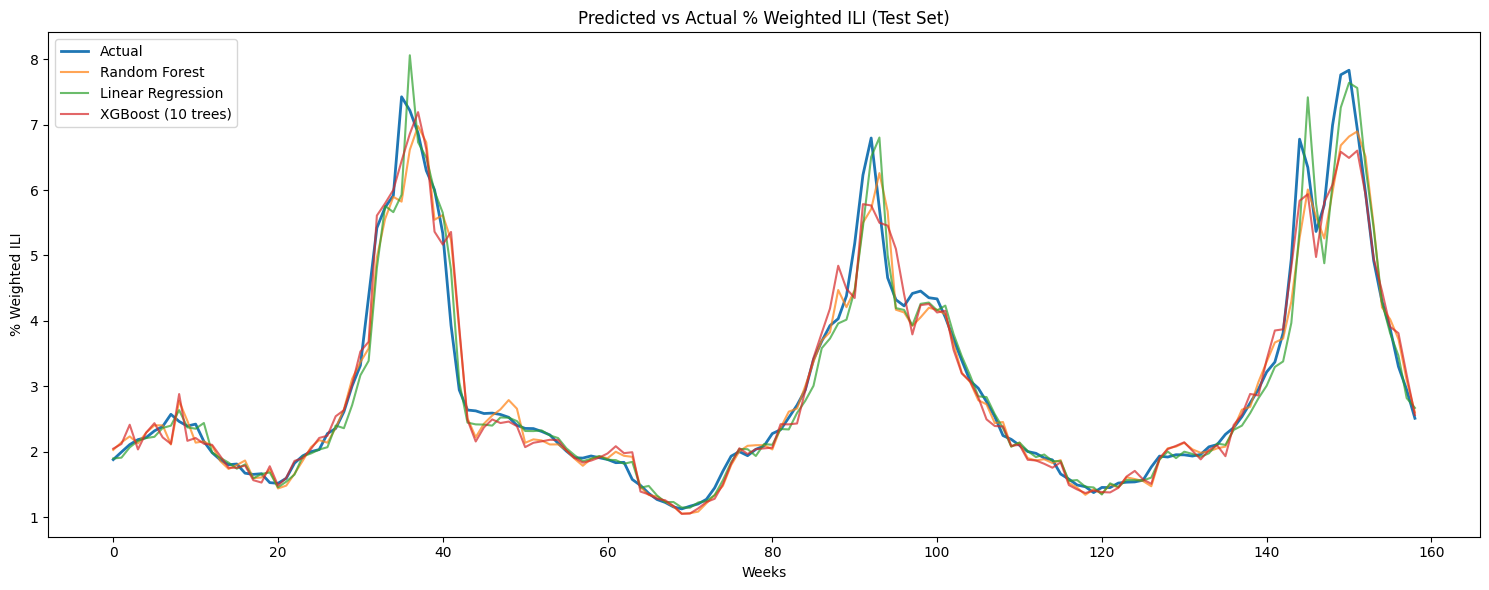

In [7]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 6))
plt.plot(y_test.values, label="Actual", linewidth=2)
plt.plot(rf_preds, label="Random Forest", alpha=0.7)
plt.plot(lr_preds, label="Linear Regression", alpha=0.7)
plt.plot(xgb_preds, label="XGBoost (10 trees)", alpha=0.7)
plt.title("Predicted vs Actual % Weighted ILI (Test Set)")
plt.xlabel("Weeks")
plt.ylabel("% Weighted ILI")
plt.legend()
plt.tight_layout()
plt.show()

### From the plots:

- All three models closely follow the actual weighted_ili values.

- XGBoost and Random Forest react quickly to spikes but may slightly overshoot.

- Linear Regression captures the general trend but is smoother and may underfit sharp peaks.

- The lag features are doing a great job at modeling the short-term flu pattern.

In [8]:
# Take the last known 5 values of weighted_ili
latest = df["weighted_ili"].iloc[-5:].tolist()

# Create a feature vector in the correct order
X_future = pd.DataFrame([{
    "weighted_ili_lag_1": latest[-1],
    "weighted_ili_lag_2": latest[-2],
    "weighted_ili_lag_3": latest[-3],
    "weighted_ili_lag_4": latest[-4],
    "weighted_ili_lag_5": latest[-5]
}])

# Predict next week
next_week_pred = xgb_model.predict(X_future)[0]
print("Predicted ILI for next week:", next_week_pred)


Predicted ILI for next week: 2.377285


In [9]:
future_weeks = 10
predictions = []

# Start with the latest known values
history = df["weighted_ili"].iloc[-5:].tolist()

for _ in range(future_weeks):
    X_future = pd.DataFrame([{
        "weighted_ili_lag_1": history[-1],
        "weighted_ili_lag_2": history[-2],
        "weighted_ili_lag_3": history[-3],
        "weighted_ili_lag_4": history[-4],
        "weighted_ili_lag_5": history[-5]
    }])
    
    pred = xgb_model.predict(X_future)[0]
    predictions.append(pred)
    history.append(pred)  # Append prediction to use it as lag in next step

# Result: predictions is a list of next 10 weeks' ILI estimates


In [10]:
start_date = df["date"].max()
future_dates = pd.date_range(start=start_date + pd.Timedelta(weeks=1), periods=future_weeks, freq='W')

forecast_df = pd.DataFrame({"date": future_dates, "predicted_ili": predictions})
print(forecast_df)


        date  predicted_ili
0 2025-04-20       2.377285
1 2025-04-27       2.132842
2 2025-05-04       1.919279
3 2025-05-11       1.746896
4 2025-05-18       1.633302
5 2025-05-25       1.540830
6 2025-06-01       1.503254
7 2025-06-08       1.288347
8 2025-06-15       1.262792
9 2025-06-22       1.235959
